<a href="https://colab.research.google.com/github/DaniloRiver/Seminario-de-Investigacion-UNAH/blob/main/Modelo_de_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Seminario de** **Investigación:** Regresión Logística



# Preliminares

In [1]:
#Librerias a Utilizar

#!pip install imbalanced-learn
#!pip install delayed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve,f1_score,auc
from sklearn.decomposition import PCA
from sklearn.model_selection import (cross_val_score,cross_val_predict,KFold)

from pylab import rcParams
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier
from collections import Counter


from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

from sklearn.metrics import precision_recall_curve,f1_score,auc
from sklearn.decomposition import PCA
from sklearn.model_selection import (cross_val_score,cross_val_predict,KFold)

import warnings
warnings.filterwarnings("ignore")



In [2]:
# scikit-learn version
import sys
import sklearn
print('sklearn: %s' % sklearn.__version__)
print(sys.version)


sklearn: 1.0.1
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [3]:
# Cargando el Dataset Diabetes
url="https://raw.githubusercontent.com/DaniloRiver/Seminario-de-Investigacion-UNAH/main/diabetes.csv"
datos= pd.read_csv(url)
datos.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Análisis Exploratorio

In [4]:
#Estadisticos para el Dataset
datos.describe()
Diabetes= datos

In [5]:
# Utilizando los primeros 200 registros de Diabetes.csv (Dimensiones)
#Diabetes=datos[:200]
Diabetes.shape

(768, 9)

In [6]:
# Utilizando los registros de Diabetes.csv (Dimensiones)
Diabetes=datos
print(Diabetes.shape)
print(pd.value_counts(Diabetes['Outcome'], sort = True))

(768, 9)
0    500
1    268
Name: Outcome, dtype: int64


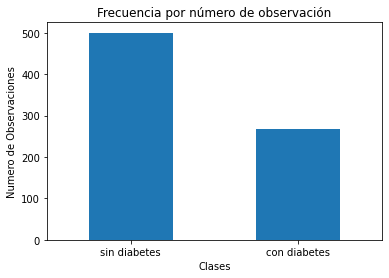

In [7]:
#Recuento de Clases
conteo_clases = pd.value_counts(Diabetes['Outcome'], sort = True)
conteo_clases.plot(kind = 'bar', rot=0)
plt.title("Frecuencia por número de observación")
plt.xlabel("Clases")
plt.ylabel("Numero de Observaciones")
plt.xticks(range(2),['sin diabetes','con diabetes'])
plt.savefig('explorar.eps',format='eps',dpi=1200,transparent=True)

In [8]:
#sns.pairplot(Diabetes)
#plt.tight_layout()

# Determinación de los Parametros Optimos para el Modelo

In [9]:
#Funcion que Calcula la metrica AUC para cada parametro dentro del dataset
def calcular_auc(variables, target, tabla_base):
    X=tabla_base[variables]
    y=tabla_base[target]
    logreg = LogisticRegression()
    logreg.fit(X, y)
    predictor = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictor)
    return(auc)


In [10]:
#Funcion que determina la mejor combinacion y cantidad de parametros a utilizar mediante Forward stepwise 
def next_best(variables_actuales,variables_candidatos, target, tabla_base):
    best_auc = -1
    best_variable = None
    for v in variables_candidatos:
        auc_v = calcular_auc(variables_actuales + [v], target, tabla_base)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
    return best_variable


In [11]:
#Se utilizaran 6 de las 8 variables dentro del dataset con mejor AUC entre ellas
variables_candidatos = ['Pregnancies','Glucose','SkinThickness','BloodPressure','DiabetesPedigreeFunction','Age','BMI']
variables_actuales = []
target = "Outcome"
maximo_numero_variables = 6
numero_iteraciones = min(maximo_numero_variables, len(variables_candidatos))
for i in range(0,numero_iteraciones):
    next_var = next_best(variables_actuales,variables_candidatos,target,Diabetes)
    variables_actuales = variables_actuales + [next_var]
    variables_candidatos.remove(next_var)
print(variables_actuales)

['Glucose', 'BMI', 'Pregnancies', 'DiabetesPedigreeFunction', 'BloodPressure', 'Age']


In [12]:
#Interpretacion de cada variable y su probabilidad AUC respectiva
auc_valor = []
variables_evaluadas = []
for v in variables_actuales:
    variables_evaluadas.append(v)
    auc_valores = calcular_auc(variables_evaluadas, "Outcome", Diabetes)
    auc_valor.append(auc_valores)

for p,c in zip(variables_evaluadas,list(auc_valor)):
    print(p + '\t\t' + str(round(c,2)))



Glucose		0.79
BMI		0.81
Pregnancies		0.83
DiabetesPedigreeFunction		0.83
BloodPressure		0.84
Age		0.84


# División y Entrenamiento de los Datos

In [13]:
# Preparando las variables X, y del modelo  X=Matriz de Predictores , y= variable de resultados  1: con diabetes , 0: sin diabetes
X=Diabetes[variables_evaluadas]
y=Diabetes.Outcome

In [14]:
# implementacion de algoritmo de entrenamiento conjunto de prueba del 25% sobre el total del dataset, algoritmo de optimizacion:
# El "lbfgs" es un algoritmo de optimización que se aproxima al algoritmo de Broyden-Fletcher-Goldfarb-Shanno ,que pertenece a los métodos cuasi-Newton. 
#"lbfgs" se utiliza por defecto por su robustez.

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size= 0.25,random_state=0)

In [15]:
#  StandardScaler() normalizará las características (cada columna de X, INDIVIDUALMENTE !!!) 
#  para que cada columna/característica/variable tenga mean = 0 y standard deviation = 1.

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)


#Modelo con Parametros Modificados

In [16]:
# Aplicacion del algoritmo de regresion logistica y entrenamiento de las variables X_train,y_train

logreg =LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [17]:
# coeficiente que corresponde a los coeficientes B (beta) que corresponden a los de la ecuacion de regresion logistica (pesos)
logreg.coef_


array([[ 0.98986246,  0.71087103,  0.29835728,  0.28849499, -0.19179062,
         0.26128227]])

In [18]:
#prediciendo los datos de prueba en base al modelo creado 
y_pred=logreg.predict(X_test)
#Matriz de confusion 
Matriz_confusion= confusion_matrix(y_test,y_pred)
print(Matriz_confusion)
print(classification_report(y_test,y_pred))

[[117  13]
 [ 26  36]]
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       130
           1       0.73      0.58      0.65        62

    accuracy                           0.80       192
   macro avg       0.78      0.74      0.75       192
weighted avg       0.79      0.80      0.79       192



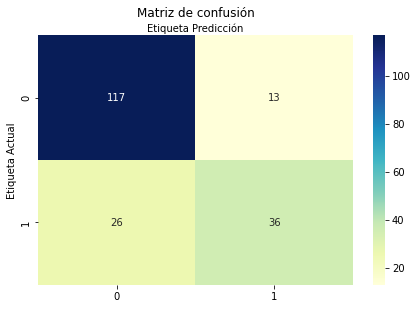

In [19]:
#Mapa de calor de la Matriz de confusion
def confusion(Matriz_confusion):
    nombre_clase=[0,1]
    fig,ax= plt.subplots()
    tick_marks=np.arange(len(nombre_clase))
    plt.xticks(tick_marks,nombre_clase)
    plt.yticks(tick_marks,nombre_clase)

    sns.heatmap(pd.DataFrame(Matriz_confusion),annot=True,cmap='YlGnBu',fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title("Matriz de confusión",y=1.1)
    plt.ylabel('Etiqueta Actual')
    plt.xlabel('Etiqueta Predicción')
    #plt.savefig('confusion1.eps',format='eps',dpi=1200)
confusion(Matriz_confusion)

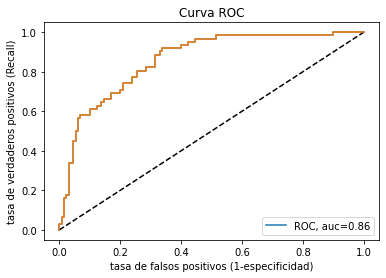

In [20]:
#Lo que estamos viendo es exactamente la curva ROC del clasificador. Y nos da bastante información: en primer lugar nos dice que aumentando o disminuyendo lo suficiente 
#el threshold podemos conseguir que nuestro algoritmo de clasificación alcance un TPR o un FPR casi perfecto.
#Cuando AUC es 0.7, significa que hay 70% de probabilidad de que el modelo pueda distinguir entre clase positiva y clase negativa. Esta es la peor situación.
#Cuando el AUC es aproximadamente 0.5, el modelo no tiene capacidad de discriminación para distinguir entre clase positiva y clase negativa.

y_pred_prob= logreg.predict_proba(X_test)[:,1]
fpr_1, tpr_1,tresholds1= roc_curve(y_test,y_pred_prob)
auc_score_1 = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr_1,tpr_1,label="ROC, auc="+str(round(auc_score_1,2)))
plt.legend(loc=4)
plt.plot([0,1],[0,1],'k--')
plt.title("Curva ROC")
plt.plot(fpr_1,tpr_1,label='Regresión Logistica')
plt.xlabel('tasa de falsos positivos (1-especificidad)')
plt.ylabel('tasa de verdaderos positivos (Recall)')
#plt.savefig('roc1.eps',format='eps', dpi=1200,transparent=True)
plt.show()

Regresión Logística: f1=0.649 auc=0.715


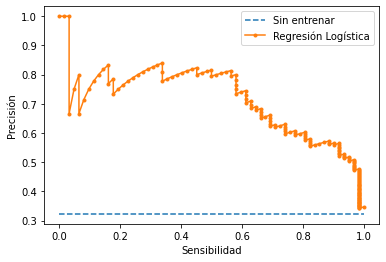

In [21]:
from matplotlib import pyplot
# predecimos probabilidades
y_pred_prob= logreg.predict_proba(X_test)[:,1]
# Sacamos los valores
yhat = logreg.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# Resumimos 
print('Regresión Logística: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# trazar las curvas de recuperación de precisión
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin entrenar')
plt.plot(lr_recall, lr_precision, marker='.', label='Regresión Logística')
#Etiquetas de ejes
plt.xlabel('Sensibilidad')
plt.ylabel('Precisión')
#plt.savefig('recall.eps',format='eps', dpi=1200,transparent=True)
plt.legend()
plt.show()




# Estrategias Para Validación y Remuestreo de los Datos (Disminuir el desbalanceo)

**Estrategia: Penalización para compensar**

In [22]:
# Aplicacion del algoritmo de regresion logistica y entrenamiento de las variables X_train,y_train

logreg_1 =LogisticRegression(class_weight='balanced')
logreg_1.fit(X_train,y_train)
y_pred_0=logreg_1.predict(X_test)
y_pred_prob_1= logreg_1.predict_proba(X_test)[:,1]
fpr_2, tpr_2,tresholds2= roc_curve(y_test,y_pred_prob_1)
auc_score_2 = roc_auc_score(y_test, y_pred_prob_1)

#Matriz de confusion 
Matriz_confusion_0= confusion_matrix(y_test,y_pred_0)
print(Matriz_confusion_0)
print(classification_report(y_test,y_pred_0))

[[104  26]
 [ 17  45]]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       130
           1       0.63      0.73      0.68        62

    accuracy                           0.78       192
   macro avg       0.75      0.76      0.75       192
weighted avg       0.79      0.78      0.78       192



**Estrategia: Subsampling en la clase mayoritaria**

In [23]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print("Distribución antes del remuestreo {}".format(Counter(y_train)))
print("Distribución después del remuestreo{}".format(Counter(y_train_res)))

modelo1=LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
modelo1.fit(X_train_res, y_train_res)
y_pred_1 = modelo1.predict(X_test)
y_pred_prob_2= modelo1.predict_proba(X_test)[:,1]
fpr_3, tpr_3,tresholds3= roc_curve(y_test,y_pred_prob_2)
auc_score_3 = roc_auc_score(y_test, y_pred_prob_2)

#Matriz de confusion
Matriz_confusion_1= confusion_matrix(y_test,y_pred_1)
print(Matriz_confusion_1)
print(classification_report(y_test,y_pred_1))


Distribución antes del remuestreo Counter({0: 370, 1: 206})
Distribución después del remuestreoCounter({0: 206, 1: 206})
[[100  30]
 [ 19  43]]
              precision    recall  f1-score   support

           0       0.84      0.77      0.80       130
           1       0.59      0.69      0.64        62

    accuracy                           0.74       192
   macro avg       0.71      0.73      0.72       192
weighted avg       0.76      0.74      0.75       192



**Estrategia: Metodo UnderSampling**

In [24]:
os = RandomUnderSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

print("Distribution before resampling {}".format(Counter(y_train)))
print("Distribution labels after resampling {}".format(Counter(y_train_res)))
modelo2=LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
modelo2.fit(X_train_res, y_train_res)
y_pred_3 = modelo2.predict(X_test)
y_pred_prob_4= modelo2.predict_proba(X_test)[:,1]
fpr_5, tpr_5,tresholds5= roc_curve(y_test,y_pred_prob_4)
auc_score_5 = roc_auc_score(y_test, y_pred_prob_4)
Matriz_confusion_3= confusion_matrix(y_test,y_pred_3)
print(Matriz_confusion_3)
print(classification_report(y_test,y_pred_3))


Distribution before resampling Counter({0: 370, 1: 206})
Distribution labels after resampling Counter({0: 206, 1: 206})
[[101  29]
 [ 16  46]]
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       130
           1       0.61      0.74      0.67        62

    accuracy                           0.77       192
   macro avg       0.74      0.76      0.74       192
weighted avg       0.78      0.77      0.77       192



**Estrategia: Oversampling de la clase minoritaria**

In [25]:
os = RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res)))

modelo3=LogisticRegression(C=1.0,penalty='l2',random_state=0)
modelo3.fit(X_train_res, y_train_res)
y_pred_4 = modelo3.predict(X_test)
y_pred_prob_5= modelo3.predict_proba(X_test)[:,1]
fpr_6, tpr_6,tresholds6= roc_curve(y_test,y_pred_prob_5)
auc_score_6 = roc_auc_score(y_test, y_pred_prob_5)
Matriz_confusion_4= confusion_matrix(y_test,y_pred_4)
print(Matriz_confusion_4)
print(classification_report(y_test,y_pred_4))

Distribution before resampling Counter({0: 370, 1: 206})
Distribution labels after resampling Counter({0: 370, 1: 370})
[[104  26]
 [ 18  44]]
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       130
           1       0.63      0.71      0.67        62

    accuracy                           0.77       192
   macro avg       0.74      0.75      0.75       192
weighted avg       0.78      0.77      0.77       192



**Estrategia: implementar K-Folds**

In [26]:
kf=KFold(n_splits=10,shuffle=True,random_state=42)
#for train,test in kf.split(Diabetes):
 # print(train)
  #print(test)


In [27]:
#modelox=LogisticRegression()
#modelox.fit(X,y)
y_pred_6= cross_val_predict(logreg,X,y,cv=kf,n_jobs=-1)
y_pred_prob_7= logreg.predict_proba(X_test)[:,1]
fpr_8, tpr_8,tresholds8= roc_curve(y_test,y_pred_prob_7)
auc_score_8 = roc_auc_score(y_test, y_pred_prob_7)
Matriz_confusion_6= confusion_matrix(y,y_pred_6)
print(Matriz_confusion_6)
print(classification_report(y,y_pred_6))

[[435  65]
 [115 153]]
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       500
           1       0.70      0.57      0.63       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.76      0.77      0.76       768



#Representando las Estrategias en la Curva ROC

In [28]:
Estrategia =['Modelo -Parametros Modificados-','Penalización para compensar','Subsampling clase mayoritaria','Ensamble de Modelos con Balanceo','UnderSampling aleatorio',' Oversampling clase minoritaria',' implementar K-Folds']


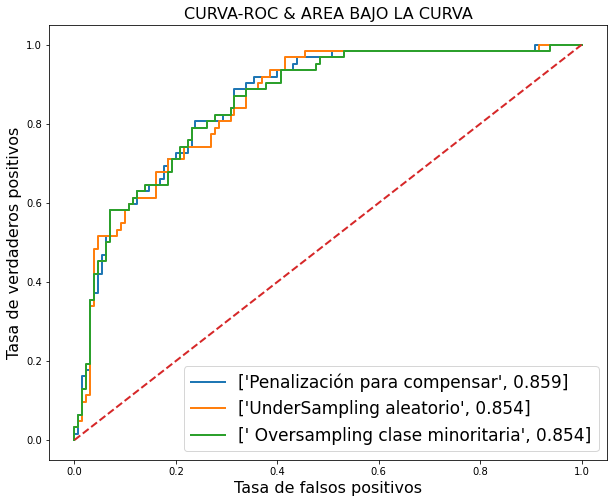

In [29]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
    
#ax.plot(fpr_1,tpr_1,label = [Estrategia[0], "AUC ROC :", round(auc_score_1,3)],linewidth=2,linestyle="solid")
ax.plot(fpr_2,tpr_2,label = [Estrategia[1], round(auc_score_2,3)],linewidth=2,linestyle="solid")
#ax.plot(fpr_3,tpr_3,label = [Estrategia[2], round(auc_score_3,3)],linewidth=2,linestyle="dotted")
#ax.plot(fpr_4,tpr_4,label = [Estrategia[3], round(auc_score_4,3)],linewidth=2,linestyle="dotted")
ax.plot(fpr_5,tpr_5,label = [Estrategia[4], round(auc_score_5,3)],linewidth=2,linestyle="solid")
ax.plot(fpr_6,tpr_6,label = [Estrategia[5], round(auc_score_6,3)],linewidth=2,linestyle="solid")
#ax.plot(fpr_8,tpr_8,label = [Estrategia[6], round(auc_score_8,3)],linewidth=2,linestyle="dotted")

ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
plt.legend(loc="Mejor",prop={'size':17})
plt.title("CURVA-ROC & AREA BAJO LA CURVA",fontsize=16)
plt.xlabel("Tasa de falsos positivos",fontsize=16)
plt.ylabel("Tasa de verdaderos positivos",fontsize=16)
#plt.savefig('roc_auc.eps',format='eps',dpi=1000,transparent=False)
plt.show()



# Curva Recall-Precision

Estrategia Penalización por Compensación


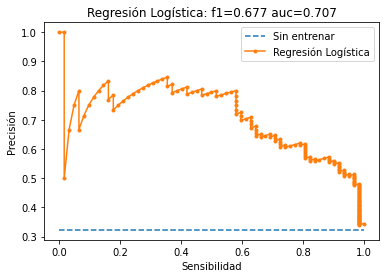


Estrategia Oversampling en la clase minoritaria


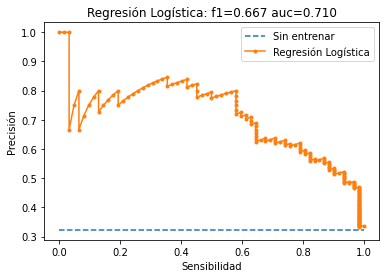


Estrategia solo Parametros Modificados


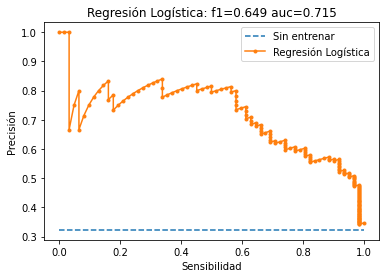


Estrategia: Undersampling Aleatorio


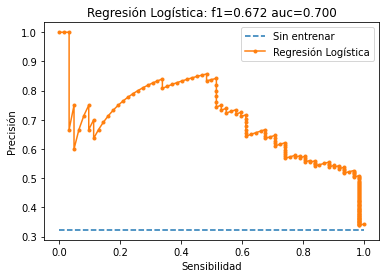

In [30]:
def Grafica_Recall_Precision(modelo,X_test,y_pred_prob,y_test):
    # Sacamos los valores
    yhat = modelo.predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob)
    lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
    # Resumimos 
    # trazar las curvas de recuperación de precisión
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin entrenar')
    plt.plot(lr_recall, lr_precision, marker='.', label='Regresión Logística')
    #Etiquetas de ejes
    plt.xlabel('Sensibilidad')
    plt.ylabel('Precisión')
    plt.title('Regresión Logística: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    plt.legend()
    #plt.savefig('recall1.eps',format='eps')
    plt.show()


print('Estrategia Penalización por Compensación')
Grafica_Recall_Precision(logreg_1,X_test,y_pred_prob_1,y_test)

print('\nEstrategia Oversampling en la clase minoritaria')
Grafica_Recall_Precision(modelo3,X_test,y_pred_prob_5,y_test)

print('\nEstrategia solo Parametros Modificados')
Grafica_Recall_Precision(logreg,X_test,y_pred_prob,y_test)

print('\nEstrategia: Undersampling Aleatorio')
Grafica_Recall_Precision(modelo2,X_test,y_pred_prob_4,y_test)

#Nuevas Estrategias de Remuestreo

In [31]:
def plot_2d_space(X, y, label='Outcome'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

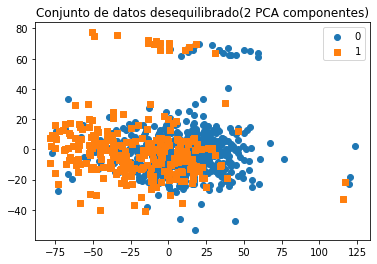

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plot_2d_space(X_pca, y, 'Conjunto de datos desequilibrado(2 PCA componentes)')

**Under-sampling: Cluster Centroids**
Esta técnica realiza un submuestreo mediante la generación de centroides basados en métodos de agrupación. Los datos se agruparán previamente por similitud, con el fin de preservar la información.

In [33]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
X_cc, y_cc = cc.fit_resample(X, y)

In [34]:
# implementacion de algoritmo de entrenamiento conjunto de prueba del 25% sobre el total del dataset, algoritmo de optimizacion:
# El "lbfgs" es un algoritmo de optimización que se aproxima al algoritmo de Broyden-Fletcher-Goldfarb-Shanno ,que pertenece a los métodos cuasi-Newton. 
#"lbfgs" se utiliza por defecto por su robustez.

X_train,X_test,y_train,y_test= train_test_split(X_cc,y_cc,test_size= 0.20,random_state=1)

In [35]:
logreg_cc =LogisticRegression()
logreg_cc.fit(X_train,y_train)
y_pred= logreg_cc.predict(X_test)

In [36]:
#prediciendo los datos de prueba en base al modelo creado 
y_pred=logreg_cc.predict(X_test)
#Matriz de confusion 
Matriz_confusion= confusion_matrix(y_test,y_pred)
print(Matriz_confusion)
print(classification_report(y_test,y_pred))

[[43  8]
 [13 44]]
              precision    recall  f1-score   support

           0       0.77      0.84      0.80        51
           1       0.85      0.77      0.81        57

    accuracy                           0.81       108
   macro avg       0.81      0.81      0.81       108
weighted avg       0.81      0.81      0.81       108



**ADASYN**

In [37]:
from imblearn.over_sampling import ADASYN

X_resampled, y_resampled = ADASYN(random_state=123).fit_resample(X, y)


In [38]:
# implementacion de algoritmo de entrenamiento conjunto de prueba del 25% sobre el total del dataset, algoritmo de optimizacion:
# El "lbfgs" es un algoritmo de optimización que se aproxima al algoritmo de Broyden-Fletcher-Goldfarb-Shanno ,que pertenece a los métodos cuasi-Newton. 
#"lbfgs" se utiliza por defecto por su robustez.

X_train,X_test,y_train,y_test= train_test_split(X_resampled,y_resampled,test_size= 0.20,random_state=1)

In [39]:
logreg_ADA =LogisticRegression()
logreg_ADA.fit(X_train,y_train)
y_pred= logreg_ADA.predict(X_test)

In [40]:
#prediciendo los datos de prueba en base al modelo creado 
y_pred=logreg_ADA.predict(X_test)
#Matriz de confusion 
Matriz_confusion= confusion_matrix(y_test,y_pred)
print(Matriz_confusion)
print(classification_report(y_test,y_pred))

[[64 31]
 [29 78]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68        95
           1       0.72      0.73      0.72       107

    accuracy                           0.70       202
   macro avg       0.70      0.70      0.70       202
weighted avg       0.70      0.70      0.70       202



**SMOTE**


In [41]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled_1, y_resampled_1 = SMOTE(random_state=123).fit_resample(X, y)

In [42]:
# implementacion de algoritmo de entrenamiento conjunto de prueba del 25% sobre el total del dataset, algoritmo de optimizacion:
# El "lbfgs" es un algoritmo de optimización que se aproxima al algoritmo de Broyden-Fletcher-Goldfarb-Shanno ,que pertenece a los métodos cuasi-Newton. 
#"lbfgs" se utiliza por defecto por su robustez.

X_train,X_test,y_train,y_test= train_test_split(X_resampled_1,y_resampled_1,test_size= 0.20,random_state=1)

In [43]:
logreg_SMOTE =LogisticRegression()
logreg_SMOTE.fit(X_train,y_train)
y_pred= logreg_SMOTE.predict(X_test)

In [44]:
#prediciendo los datos de prueba en base al modelo creado 
y_pred=logreg_SMOTE.predict(X_test)
#Matriz de confusion 
Matriz_confusion= confusion_matrix(y_test,y_pred)
print(Matriz_confusion)
print(classification_report(y_test,y_pred))

[[78 33]
 [22 67]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       111
           1       0.67      0.75      0.71        89

    accuracy                           0.73       200
   macro avg       0.73      0.73      0.72       200
weighted avg       0.73      0.72      0.73       200



#Over-sampling seguido por under-sampling Regresion Logistica
Se usa una combinación de sobremuestreo y submuestreo, utilizando las técnicas de enlaces SMOTE y Tomek:

In [45]:
from imblearn.combine import SMOTEENN

X_resampled, y_resampled = SMOTEENN(random_state=123).fit_resample(X, y)

In [46]:
# implementacion de algoritmo de entrenamiento conjunto de prueba del 25% sobre el total del dataset, algoritmo de optimizacion:
# El "lbfgs" es un algoritmo de optimización que se aproxima al algoritmo de Broyden-Fletcher-Goldfarb-Shanno ,que pertenece a los métodos cuasi-Newton. 
#"lbfgs" se utiliza por defecto por su robustez.

X_train,X_test,y_train,y_test= train_test_split(X_resampled,y_resampled,test_size= 0.20,random_state=1)

In [47]:
logreg_smt =LogisticRegression()
logreg_smt.fit(X_train,y_train)
y_pred= logreg_smt.predict(X_test)

In [48]:
#prediciendo los datos de prueba en base al modelo creado 
y_pred=logreg_smt.predict(X_test)
#Matriz de confusion 
Matriz_confusion= confusion_matrix(y_test,y_pred)
print(Matriz_confusion)
print(classification_report(y_test,y_pred))

[[44  4]
 [ 7 57]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        48
           1       0.93      0.89      0.91        64

    accuracy                           0.90       112
   macro avg       0.90      0.90      0.90       112
weighted avg       0.90      0.90      0.90       112



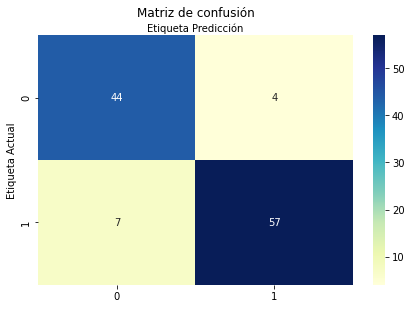

In [49]:
#Mapa de calor de la Matriz de confusion
def confusion(Matriz_confusion):
    nombre_clase=[0,1]
    fig,ax= plt.subplots()
    tick_marks=np.arange(len(nombre_clase))
    plt.xticks(tick_marks,nombre_clase)
    plt.yticks(tick_marks,nombre_clase)

    sns.heatmap(pd.DataFrame(Matriz_confusion),annot=True,cmap='YlGnBu',fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title("Matriz de confusión",y=1.1)
    plt.ylabel('Etiqueta Actual')
    plt.xlabel('Etiqueta Predicción')
    #plt.savefig('confusion1.eps',format='eps',dpi=1200)
confusion(Matriz_confusion)

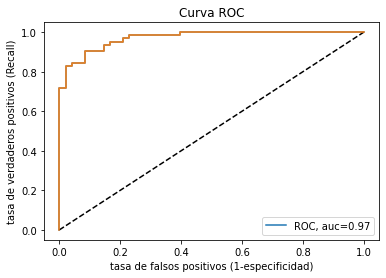

In [50]:
#Lo que estamos viendo es exactamente la curva ROC del clasificador. Y nos da bastante información: en primer lugar nos dice que aumentando o disminuyendo lo suficiente 
#el threshold podemos conseguir que nuestro algoritmo de clasificación alcance un TPR o un FPR casi perfecto.
#Cuando AUC es 0.7, significa que hay 70% de probabilidad de que el modelo pueda distinguir entre clase positiva y clase negativa. Esta es la peor situación.
#Cuando el AUC es aproximadamente 0.5, el modelo no tiene capacidad de discriminación para distinguir entre clase positiva y clase negativa.

y_pred_prob= logreg_smt.predict_proba(X_test)[:,1]
fpr_11, tpr_11,tresholds11= roc_curve(y_test,y_pred_prob)
auc_score_11 = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr_11,tpr_11,label="ROC, auc="+str(round(auc_score_11,2)))
plt.legend(loc=4)
plt.plot([0,1],[0,1],'k--')
plt.title("Curva ROC")
plt.plot(fpr_11,tpr_11,label='Regresión Logistica')
plt.xlabel('tasa de falsos positivos (1-especificidad)')
plt.ylabel('tasa de verdaderos positivos (Recall)')
#plt.savefig('roc1.eps',format='eps', dpi=1200,transparent=True)
plt.show()

Regresión Logística: f1=0.912 auc=0.980


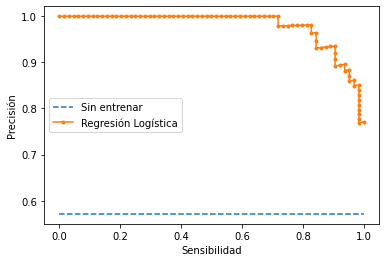

In [51]:
from matplotlib import pyplot
# predecimos probabilidades
y_pred_prob= logreg_smt.predict_proba(X_test)[:,1]
# Sacamos los valores
yhat = logreg_smt.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# Resumimos 
print('Regresión Logística: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# trazar las curvas de recuperación de precisión
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin entrenar')
plt.plot(lr_recall, lr_precision, marker='.', label='Regresión Logística')
#Etiquetas de ejes
plt.xlabel('Sensibilidad')
plt.ylabel('Precisión')
#plt.savefig('recall.eps',format='eps', dpi=1200,transparent=True)
plt.legend()
plt.show()




#Arbol de Decision

**Sin Modificacion de Datos**

In [52]:
# implementacion de algoritmo de entrenamiento conjunto de prueba del 25% sobre el total del dataset, algoritmo de optimizacion:
# El "lbfgs" es un algoritmo de optimización que se aproxima al algoritmo de Broyden-Fletcher-Goldfarb-Shanno ,que pertenece a los métodos cuasi-Newton. 
#"lbfgs" se utiliza por defecto por su robustez.

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size= 0.20,random_state=1)

In [53]:
Arbol=DecisionTreeClassifier(max_depth=5,random_state=1)
Arbol.fit(X_train,y_train)
y_pred= Arbol.predict(X_test)

In [54]:
#prediciendo los datos de prueba en base al modelo creado 
y_pred=Arbol.predict(X_test)
#Matriz de confusion 
Matriz_confusion0= confusion_matrix(y_test,y_pred)
print(Matriz_confusion0)
print(classification_report(y_test,y_pred))

[[82 17]
 [22 33]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        99
           1       0.66      0.60      0.63        55

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154



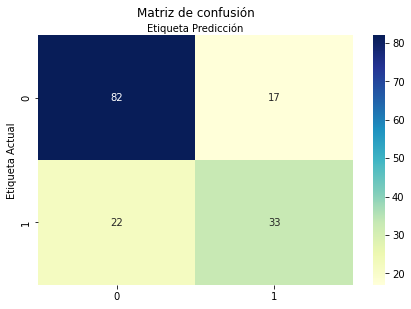

In [55]:
#Mapa de calor de la Matriz de confusion
def confusion(Matriz_confusion):
    nombre_clase=[0,1]
    fig,ax= plt.subplots()
    tick_marks=np.arange(len(nombre_clase))
    plt.xticks(tick_marks,nombre_clase)
    plt.yticks(tick_marks,nombre_clase)

    sns.heatmap(pd.DataFrame(Matriz_confusion),annot=True,cmap='YlGnBu',fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title("Matriz de confusión",y=1.1)
    plt.ylabel('Etiqueta Actual')
    plt.xlabel('Etiqueta Predicción')
    #plt.savefig('confusion1.eps',format='eps',dpi=1200)
confusion(Matriz_confusion0)


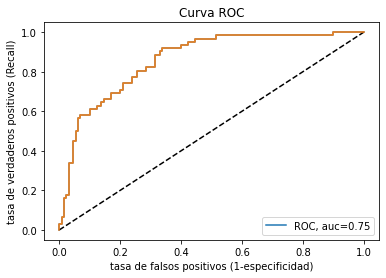

In [56]:
#Lo que estamos viendo es exactamente la curva ROC del clasificador. Y nos da bastante información: en primer lugar nos dice que aumentando o disminuyendo lo suficiente 
#el threshold podemos conseguir que nuestro algoritmo de clasificación alcance un TPR o un FPR casi perfecto.
#Cuando AUC es 0.7, significa que hay 70% de probabilidad de que el modelo pueda distinguir entre clase positiva y clase negativa. Esta es la peor situación.
#Cuando el AUC es aproximadamente 0.5, el modelo no tiene capacidad de discriminación para distinguir entre clase positiva y clase negativa.


y_pred_prob= Arbol.predict_proba(X_test)[:,1]
fpr_99, tpr_99,tresholds1= roc_curve(y_test,y_pred_prob)
auc_score_99 = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr_1,tpr_1,label="ROC, auc="+str(round(auc_score_99,2)))
plt.legend(loc=4)
plt.plot([0,1],[0,1],'k--')
plt.title("Curva ROC")
plt.plot(fpr_1,tpr_1,label='Regresión Logistica')
plt.xlabel('tasa de falsos positivos (1-especificidad)')
plt.ylabel('tasa de verdaderos positivos (Recall)')
#plt.savefig('roc1.eps',format='eps', dpi=1200,transparent=True)
plt.show()




#Over-sampling seguido por under-sampling (Arbol de Decision)



In [57]:
from imblearn.combine import SMOTEENN

X_resampled1, y_resampled1 = SMOTEENN(random_state=123).fit_resample(X, y)


In [58]:
# implementacion de algoritmo de entrenamiento conjunto de prueba del 25% sobre el total del dataset, algoritmo de optimizacion:
# El "lbfgs" es un algoritmo de optimización que se aproxima al algoritmo de Broyden-Fletcher-Goldfarb-Shanno ,que pertenece a los métodos cuasi-Newton. 
#"lbfgs" se utiliza por defecto por su robustez.

X_train,X_test,y_train,y_test= train_test_split(X_resampled1,y_resampled1,test_size= 0.20,random_state=1)

In [59]:
Arbol2=DecisionTreeClassifier(max_depth=5,random_state=1)
Arbol2.fit(X_train,y_train)
y_pred= Arbol2.predict(X_test)

In [60]:
#prediciendo los datos de prueba en base al modelo creado 
y_pred=Arbol2.predict(X_test)
#Matriz de confusion 
Matriz_confusion= confusion_matrix(y_test,y_pred)
print(Matriz_confusion)
print(classification_report(y_test,y_pred))

[[40  8]
 [ 4 60]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        48
           1       0.88      0.94      0.91        64

    accuracy                           0.89       112
   macro avg       0.90      0.89      0.89       112
weighted avg       0.89      0.89      0.89       112



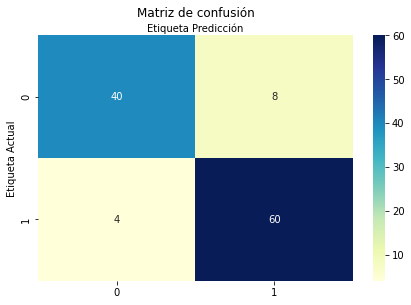

In [61]:
#Mapa de calor de la Matriz de confusion
def confusion(Matriz_confusion):
    nombre_clase=[0,1]
    fig,ax= plt.subplots()
    tick_marks=np.arange(len(nombre_clase))
    plt.xticks(tick_marks,nombre_clase)
    plt.yticks(tick_marks,nombre_clase)

    sns.heatmap(pd.DataFrame(Matriz_confusion),annot=True,cmap='YlGnBu',fmt='g')
    ax.xaxis.set_label_position('top')
    plt.tight_layout()
    plt.title("Matriz de confusión",y=1.1)
    plt.ylabel('Etiqueta Actual')
    plt.xlabel('Etiqueta Predicción')
    #plt.savefig('confusion1.eps',format='eps',dpi=1200)
confusion(Matriz_confusion)

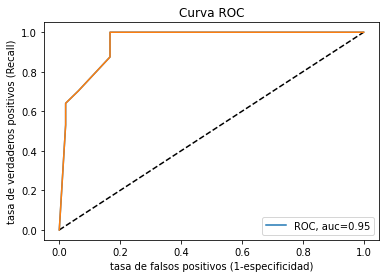

In [62]:
y_pred_prob3= Arbol2.predict_proba(X_test)[:,1]
fpr_44, tpr_44,tresholds44= roc_curve(y_test,y_pred_prob3)
auc_score_44 = roc_auc_score(y_test, y_pred_prob3)
plt.plot(fpr_44,tpr_44,label="ROC, auc="+str(round(auc_score_44,2)))
plt.legend(loc=4)
plt.plot([0,1],[0,1],'k--')
plt.title("Curva ROC")
plt.plot(fpr_44,tpr_44,label='Regresión Logistica')
plt.xlabel('tasa de falsos positivos (1-especificidad)')
plt.ylabel('tasa de verdaderos positivos (Recall)')
#plt.savefig('roc1.eps',format='eps', dpi=1200,transparent=True)
plt.show()

Regresión Logística: f1=0.909 auc=0.956


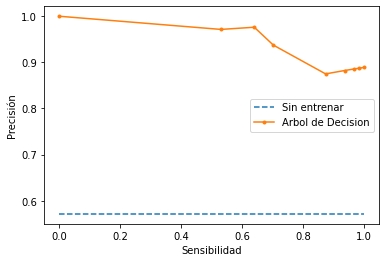

In [63]:
# predecimos probabilidades
y_pred_prob= Arbol2.predict_proba(X_test)[:,1]
# Sacamos los valores
yhat = Arbol2.predict(X_test)
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
# Resumimos 
print('Regresión Logística: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# trazar las curvas de recuperación de precisión
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin entrenar')
plt.plot(lr_recall, lr_precision, marker='.', label='Arbol de Decision')
#Etiquetas de ejes
plt.xlabel('Sensibilidad')
plt.ylabel('Precisión')
#plt.savefig('recall.eps',format='eps', dpi=1200,transparent=True)
plt.legend()
plt.show()




#Comparacion Modelos Regresion Logistica y Arbol de Decision (Curva ROC)

In [64]:
Estrategia =['  Regresion Logistica -sin Modificacion-','Regresion Logistica SMOOTEEN','Arbol de Decision -sin Modificacion-','Arbol de Decision SMOTEENN']

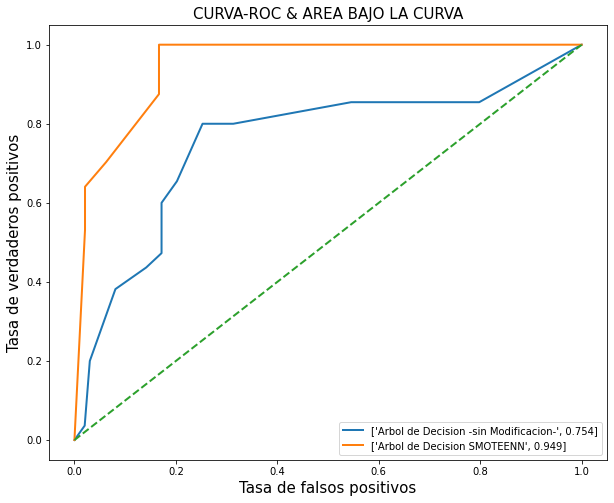

In [65]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111)
    
#ax.plot(fpr_1,tpr_1,label = [Estrategia[0], round(auc_score_1,3)],linewidth=2,linestyle="solid")
#ax.plot(fpr_11,tpr_11,label = [Estrategia[1], round(auc_score_11,3)],linewidth=2,linestyle="solid")
#ax.plot(fpr_3,tpr_3,label = [Estrategia[2], round(auc_score_3,3)],linewidth=2,linestyle="dotted")
#ax.plot(fpr_4,tpr_4,label = [Estrategia[3], round(auc_score_4,3)],linewidth=2,linestyle="dotted")
ax.plot(fpr_99,tpr_99,label = [Estrategia[2], round(auc_score_99,3)],linewidth=2,linestyle="solid")
ax.plot(fpr_44,tpr_44,label = [Estrategia[3], round(auc_score_44,3)],linewidth=2,linestyle="solid")
#ax.plot(fpr_8,tpr_8,label = [Estrategia[6], round(auc_score_8,3)],linewidth=2,linestyle="dotted")

ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.legend(loc="Mejor",prop={'size':10})
plt.title("CURVA-ROC & AREA BAJO LA CURVA",fontsize=15)
plt.xlabel("Tasa de falsos positivos",fontsize=15)
plt.ylabel("Tasa de verdaderos positivos",fontsize=15)
#plt.savefig('roc_auc.eps',format='eps',dpi=1000,transparent=False)
plt.show()

